In [34]:
import pandas as pd
import numpy as np

df_client = pd.read_csv('../data/dim_client.csv')
df_loan = pd.read_csv('../data/loan_details.csv')

A major part of the data cleaning process focused on the INDUSTRY and SUB_INDUSTRY columns, which contained vague, inconsistent, and misclassified entries. To ensure accuracy and consistency, values were standardized using the GICS (Global Industry Classification Standard) framework, aligning all records with globally recognized industry definitions.

Reference: https://www.spglobal.com/marketintelligence/en/documents/112727-gics-mapbook_2018_v3_letter_digitalspreads.pdf

Before we can analyze anything, we need clean, reliable data.
Raw datasets often contain missing values, duplicates, and inconsistencies that can distort results.
Cleaning the data ensures our insights are accurate, meaningful, and truly reflective of business realities.

## Functions

In [35]:
def summarize_missing_values(df):
    """Print missing values and specific 'NA' string values per column."""
    print("\nMissing / 'NA' values per column:")
    for col in df.columns:
        missing_count = df[col].isna().sum()
        na_str_count = (df[col] == 'NA').sum() if df[col].dtype == 'object' else 0
        print(f"  {col}: missing={missing_count}, 'NA' strings={na_str_count}")

def value_counts_summary(df, col):
    """Print unique value count and full distribution."""
    print("Unique values:", df[col].nunique())
    print(df[col].value_counts(dropna=False))

    print("\nAll unique values (for inspection):")
    print(df[col].unique())

# Client Details

## Initial EDA

In [36]:
df_client.shape

(162332, 5)

In [37]:
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162332 entries, 0 to 162331
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   CLIENT_UUID   162332 non-null  int64 
 1   COMPANY_SIZE  25402 non-null   object
 2   INDUSTRY      43866 non-null   object
 3   SUB_INDUSTRY  30721 non-null   object
 4   COMPANY_TYPE  39674 non-null   object
dtypes: int64(1), object(4)
memory usage: 6.2+ MB


The client data had large gaps — with most fields like company size, industry, and type missing for the majority of records. Analyzing this without cleaning would lead to unreliable insights. That’s why initial filtering and validation were essential.

In [38]:
df_client.sample(10)

,CLIENT_UUID,COMPANY_SIZE,INDUSTRY,SUB_INDUSTRY,COMPANY_TYPE
127174,104794,01-Oct,Healthcare equipment,Managed Health Care,NaN
84850,131971,Oct-49,Commercial & Professional Services,Environmental & Facilities Services,NaN
9548,170530,NaN,NaN,NaN,NaN
98960,51168,NaN,NaN,NaN,NaN
30454,67601,NaN,NaN,NaN,NaN
29115,143341,NaN,NaN,NaN,NaN
21764,199823,NaN,NaN,NaN,NaN
38349,139986,NaN,NaN,NaN,NaN
144949,67487,NaN,NaN,NaN,NaN
121208,160343,NaN,Construction,Industrial Machinery,NaN


In [39]:
summarize_missing_values(df_client)


Missing / 'NA' values per column:
  CLIENT_UUID: missing=0, 'NA' strings=0
  COMPANY_SIZE: missing=136930, 'NA' strings=0
  INDUSTRY: missing=118466, 'NA' strings=0
  SUB_INDUSTRY: missing=131611, 'NA' strings=0
  COMPANY_TYPE: missing=122658, 'NA' strings=0


CLIENT_UUID has complete data, which is crucial since it uniquely identifies each client. However, other fields like industry, company type, and company size have high missing rates

In [40]:
value_counts_summary(df_client, 'COMPANY_SIZE')

Unique values: 15
COMPANY_SIZE
NaN              136930
01-Oct            11040
less than 10       5272
Oct-49             3329
more than 200      1722
Nov-20              955
More than 200       684
100 - 199           543
50 - 99             486
21-30               408
41-50               217
31-40               216
76-100              177
51-75               136
101-150             114
151-200             103
Name: count, dtype: int64

All unique values (for inspection):
[nan 'less than 10' 'Oct-49' '41-50' '01-Oct' '50 - 99' '21-30' 'Nov-20'
 '31-40' 'More than 200' '100 - 199' 'more than 200' '51-75' '76-100'
 '151-200' '101-150']


The COMPANY_SIZE column has inconsistent formatting (e.g., "1-10" vs. "less than 10", "More than 200" vs. "more than 200") and many unique ranges, making it messy and difficult to analyze without standardization.

In [41]:
value_counts_summary(df_client, 'COMPANY_TYPE')

Unique values: 3
COMPANY_TYPE
NaN            122658
single          25886
corporation     11675
partnership      2113
Name: count, dtype: int64

All unique values (for inspection):
['corporation' 'single' nan 'partnership']


In [42]:
value_counts_summary(df_client, 'INDUSTRY')

Unique values: 60
INDUSTRY
NaN                                118466
Food & Staples Retailing             7054
Services                             6848
Food, Beverage & Tobacco             4197
Trading                              3509
                                    ...  
Household and Personal Products         1
engineering services                    1
Printing Services                       1
trading                                 1
logistics  and trucking                 1
Name: count, Length: 61, dtype: int64

All unique values (for inspection):
[nan 'Consumer Services' 'Services' 'Specialized Construction' 'Trading'
 'Food, Beverage & Tobacco' 'Semiconductors & Semiconductor Equipment'
 'Food & Staples Retailing' 'Manufacturing' 'Media' 'Construction'
 'Transportation' 'Real Estate' 'Commercial & Professional Services'
 'Insurance' 'Consumer Durables & Apparel'
 'Pharmaceuticals, Biotechnology & Life Sciences'
 'Household & Personal Products' 'Software & Services'
 'Techno

The INDUSTRY column contains many inconsistent and duplicated labels ( different spellings, casing, and phrasing for the same industry)

In [43]:
value_counts_summary(df_client, 'SUB_INDUSTRY')

Unique values: 264
SUB_INDUSTRY
NaN                                       131611
Trading Companies & Distributors            1746
Food Retail                                 1469
Food                                        1465
Food and beverage                            944
                                           ...  
Integrated Telecommunications Services         1
Asset Management & Custody Banks               1
Trading Companies and Distributors             1
Construction Engineering                       1
Human Resources & Employment Services          1
Name: count, Length: 265, dtype: int64

All unique values (for inspection):
[nan 'Other construction installation' 'Packaged Foods & Meats'
 'Distributors' 'Media & advertising' 'Specialized Finance'
 'Construction & Engineering' 'Installation of electrical systems'
 'Trucking' 'Real Estate Services' 'Multi-line Insurance'
 'Apparel, Accessories & Luxury Goods' 'Pharmaceuticals'
 'IT Consulting & Other Services' 'Accommodatio

The SUB_INDUSTRY column contains many inconsistent and duplicated labels ( different spellings, casing, and phrasing for the same industry)

## Data Cleaning

In [44]:
df_client_clean = df_client.copy()

### Company_size

In [45]:
# Normalize COMPANY_SIZE values to lowercase and strip whitespace
# More than 200 -> more than 200
df_client_clean['COMPANY_SIZE'] = df_client_clean['COMPANY_SIZE'].str.lower().str.strip()

In [46]:
# Remove spaces around dash ("10 - 49" -> "10-49")
df_client_clean['COMPANY_SIZE'] = df_client_clean['COMPANY_SIZE'].str.replace(r'\s*-\s*', '-', regex=True)


In [49]:
# fixing overlaps and standardizing 
mapping = {

    'less than 10': '1-10',
    '01-oct': '1-10',
    'oct-49': '10-49',
    'nov-20': '10-49',
    '11-20': '10-49',
    '21-30': '10-49',
    '31-40': '10-49',
    '41-50': '10-49',
    '51-75': '50-99',
    '76-100': '50-99',
    '101-150': '100-199',
    '151-200': '100-199',
    'more than 200': '200+',
    
    

}

# Replace using the mapping
df_client_clean['COMPANY_SIZE'] = df_client_clean['COMPANY_SIZE'].replace(mapping)

In [50]:
print("Unique values in COMPANY_SIZE:", df_client_clean['COMPANY_SIZE'].nunique())
print(df_client_clean['COMPANY_SIZE'].value_counts(dropna=False).head(10))

print("\nAll unique values (for inspection):")
print(df_client_clean['COMPANY_SIZE'].unique())


Unique values in COMPANY_SIZE: 5
COMPANY_SIZE
NaN        136930
1-10        16312
10-49        5125
200+         2406
50-99         799
100-199       760
Name: count, dtype: int64

All unique values (for inspection):
[nan '1-10' '10-49' '50-99' '200+' '100-199']


### Industry

In [51]:
#standardize into a single format
df_client_clean['INDUSTRY'] = df_client_clean['INDUSTRY'].str.lower().str.strip()


In [52]:
# standardizing industry names

df_client_clean['INDUSTRY'] = df_client_clean['INDUSTRY'].replace({
    'food, beverage, tobacco': 'food, beverage & tobacco',
    'food/beverage & tobacco': 'food, beverage & tobacco',
    'household and personal products': 'household & personal products'
})


In [53]:
# making blank null
df_client_clean['INDUSTRY'] = df_client_clean['INDUSTRY'].replace({'blank': np.nan})

### SUB INDUSTRY

In [54]:
#standardize into a single format
df_client_clean['SUB_INDUSTRY'] = df_client_clean['SUB_INDUSTRY'].str.lower().str.strip()


In [55]:
subindustry_replacements = {
    'construction and engineering': 'construction & engineering',
    'construction engineering': 'construction & engineering',
    'trading companies and distributors': 'trading companies & distributors'
}

df_client_clean['SUB_INDUSTRY'] = df_client_clean['SUB_INDUSTRY'].replace(subindustry_replacements)

Looking further into the data to analyze the industries and subindustries

In [681]:
industry_to_subindustries_counts = (
    df_client_clean.groupby('INDUSTRY')['SUB_INDUSTRY']
    .value_counts()
    .sort_index()
)

from collections import defaultdict

# Organize counts into a nested dictionary for formatting
industry_dict = defaultdict(dict)
for (industry, subindustry), count in industry_to_subindustries_counts.items():
    industry_dict[industry][subindustry] = count

# Print nicely
for industry, subindustries in industry_dict.items():
    print(f"\n{industry}:")
    for subindustry, count in subindustries.items():
        print(f"  {subindustry}: {count}")



automobiles & components:
  auto parts & equipment: 245
  automobile & other machinery: 49
  automobile manufacturers: 61
  automotive retail: 50
  motorcycle manufacturers: 46
  tires & rubber: 32

banks:
  automobile manufacturers: 1
  diversified banks: 69
  furniture: 1
  regional banks: 78
  thrifts & mortgage finance: 54

commercial & professional services:
  commercial printing: 93
  construction - services: 7
  construction materials: 13
  construction – manpower: 6
  data processing & outsourced services: 83
  diversified support services: 161
  environmental & facilities services: 113
  hospitals & healthcare: 1
  human resource & employment services: 288
  it consulting & other services: 30
  office services & supplies: 252
  printing: 23
  research & consulting services: 234
  research & development: 19
  security & alarm services: 73
  security services: 12
  specialized consumer services: 27
  specialized finance: 39

construction:
  aerospace & defense: 18
  agricultura

### industries existing only once and without subindustries (merge with other industries)

In [ ]:

replacements = {
    'printing services': ('services', 'printing'),
    'trucking': ('transportation', 'trucking'),
    'engineering services': ('specialized construction', 'architectural, engineering and interior design services'),
    'agriculture': ('manufacturing', 'farming & agriculture'),
    'pharmaceutical': ('pharmaceuticals, biotechnology & life sciences', 'pharmaceuticals'),
    'construction & hardware materials': ('specialized construction', 'construction & hardware materials'),
    'manufacturing/fabrication': ('manufacturing', 'raw materials'),
    'catering': ('services', 'catering'),
    'international consultancy': ('commercial & professional services', 'research & consulting services'),
    'logistics  and trucking': ('transportation', 'logistics & transportation'),
}

for old_industry, (new_industry, new_subindustry) in replacements.items():
    mask = df_client_clean['INDUSTRY'] == old_industry
    df_client_clean.loc[mask, 'INDUSTRY'] = new_industry
    df_client_clean.loc[mask, 'SUB_INDUSTRY'] = new_subindustry


In [683]:
print("Unique values in INDUSTRY:", df_client_clean['INDUSTRY'].nunique())


Unique values in INDUSTRY: 27


### fixing misclassified subindustries

In [684]:
reassignments = {
    ('banks', 'automobile manufacturers'): 'automobiles & components',
    ('banks', 'furniture'): 'household & personal products',
    ('commercial & professional services', 'construction materials'): 'construction',
    ('commercial & professional services', 'construction – manpower'): 'construction',
    ('commercial & professional services', 'hospitals & healthcare'): 'healthcare equipment',
    ('construction', 'agricultural & farm machinery'): 'manufacturing',
    ('construction', 'computer & electronics retail'): 'technology hardware & equipment',
    ('construction', 'food distributors'): 'food, beverage & tobacco',
    ('consumer durables & apparel', 'commercial printing'): 'commercial & professional services',
    ('consumer durables & apparel', 'food'): 'food, beverage & tobacco',
    ('consumer durables & apparel', 'commerical electronics'): 'technology hardware & equipment',
    ('consumer services', 'general merchandise stores'): 'food & staples retailing',
    ('consumer services', 'trading companies & distributors'): 'trading',
    ('diversified financials', 'trading companies & distributors'): 'trading',
    ('food & staples retailing', 'automobile & other machinery'): 'automobiles & components',
    ('food & staples retailing', 'automotive retail'): 'automobiles & components',
    ('food & staples retailing', 'computer & electronics retail'): 'technology hardware & equipment',
    ('food & staples retailing', 'construction materials'): 'construction',
    ('food & staples retailing', 'environmental & facilities services'): 'commercial & professional services',
    ('food & staples retailing', 'marine ports & services'): 'transportation',
    ('food & staples retailing', 'multi-level marketing'): 'services',
    ('food & staples retailing', 'office services & supplies'): 'commercial & professional services',
    ('food & staples retailing', 'restaurants'): 'consumer services',
    ('food & staples retailing', 'food distributors'): 'food, beverage & tobacco',
    ('food, beverage & tobacco', 'catering'): 'services',
    ('food, beverage & tobacco', 'food retail'): 'food & staples retailing',
    ('food, beverage & tobacco', 'general merchandise'): 'food & staples retailing',
    ('food, beverage & tobacco', 'grocery and convenience store – regular'): 'food & staples retailing',
    ('food, beverage & tobacco', 'household products'): 'household & personal products',
    ('food, beverage & tobacco', 'telecommunications'): 'telecommunication services',
    ('household & personal products', 'agricultural & farm machinery'): 'manufacturing',
    ('household & personal products', 'food retail'): 'food & staples retailing',
    ('installation', 'building completion and finishing'): 'specialized construction',
    ('installation', 'construction & engineering'): 'construction',
    ('installation', 'electronic devices'): 'technology hardware & equipment',
    ('installation', 'electronics goods'): 'technology hardware & equipment',
    ('installation', 'heavy electrical equipment'): 'technology hardware & equipment',
    ('installation', 'telecommunications'): 'telecommunication services',
    ('materials', 'electronic devices'): 'technology hardware & equipment',
    ('materials', 'construction materials'): 'construction',
    ('materials', 'general merchandise stores'): 'food & staples retailing',
    ('media', 'specialty chemicals'): 'materials',
    ('pharmaceuticals, biotechnology & life sciences', 'heavy electrical equipment'): 'technology hardware & equipment',
    ('real estate', 'publishing'): 'media',
    ('semiconductors & semiconductor equipment', 'business consulting'): 'services',
    ('semiconductors & semiconductor equipment', 'electrical components & equipment'): 'technology hardware & equipment',
    ('semiconductors & semiconductor equipment', 'electrical goods'): 'technology hardware & equipment',
    ('semiconductors & semiconductor equipment', 'industrial materials'): 'materials',
    ('semiconductors & semiconductor equipment', 'semiconductors'): 'materials',
    ('specialized construction', 'construction & hardware materials'): 'construction',
    ('technology hardware & equipment', 'industrial equipment'): 'materials',
    ('technology hardware & equipment', 'industrial machinery'): 'materials',
    ('technology hardware & equipment', 'it consulting & other services'): 'software & services',
    ('technology hardware & equipment', 'trading companies & distributors'): 'trading',
    ('trading', 'auto parts & equipment'): 'automobiles & components',
    ('trading', 'automobile & other machinery'): 'automobiles & components',
    ('trading', 'consumer electronics'): 'technology hardware & equipment',
    ('trading', 'cosmetics and beauty supplies'): 'household & personal products',
    ('trading', 'electronics'): 'technology hardware & equipment',
    ('trading', 'fashion, apparel, and accessories'): 'consumer durables & apparel',
    ('trading', 'food and beverage'): 'services',
    ('trading', 'furniture'): 'household & personal products',
    ('trading', 'general merchandise'): 'food & staples retailing',
    ('trading', 'industrial equipment'): 'materials',
    ('trading', 'integrated oil & gas'): 'energy',
    ('trading', 'office supplies'): 'materials',
    ('trading', 'raw materials'): 'materials',
    ('trading', 'health & medical supplies & construction materials'): 'healthcare equipment',
    ('trading', 'health and medical supplies'): 'healthcare equipment',
    ('transportation', 'cosmetics and beauty supplies'): 'household & personal products',
    ('transportation', 'education'): 'services',
    ('transportation', 'farming & agriculture'): 'manufacturing', 
    ('transportation', 'household products'): 'household & personal products',
    
}

for (old_industry, sub_industry), new_industry in reassignments.items():
    mask = (df_client_clean['INDUSTRY'] == old_industry) & (df_client_clean['SUB_INDUSTRY'] == sub_industry)
    df_client_clean.loc[mask, 'INDUSTRY'] = new_industry

### grouping and merging per industry

In [685]:
industry_subindustry_merge_map = {
    ("automobiles & components", "automobile & other machinery"): "automobile manufacturers",
    ("commercial & professional services", "printing"): "commercial printing",
    ("commercial & professional services", "security services"): "security & alarm services",
    ("commercial & professional services", "construction - services"): "construction & engineering",
    ("commercial & professional services", "research & development"): "research & consulting services",
    ("construction", "construction of buildings"): "construction & engineering",
    ("construction", "construction & hardware materials"): "construction materials",
    ("construction", "construction of civil engineering works"): "construction & engineering",
    ("construction", "construction of other civil engineering projects"): "construction & engineering",
    ("construction", "other construction-related activities"): "construction & engineering",
    ("construction", "construction – manpower"): "construction & engineering",
    ("construction", "installation of electrical systems"): "electrical components & equipment",
    ("consumer durables & apparel", "fashion, apparel, and accessories"): "apparel, accessories & luxury goods",
    ("consumer durables & apparel", "boating"): "leisure products",
    ('materials', 'boating'): 'leisure products',
    ("consumer durables & apparel", "sports equipment"): "leisure products",
    ("consumer services", "accommodation & hospitality"): "hotels, resorts & cruise lines",
    ("consumer services", "travel agent / logistics"): "hotels, resorts & cruise lines",
    ("consumer services", "catering"): "diversified support services",
    ("energy", "coal and consumable fuels"): "coal & consumable fuels",
    ("energy", "gas distribution"): "gas utilities",
    ("food & staples retailing", "general merchandise"): "general merchandise stores",
    ("food & staples retailing", "general corporate merchandise"): "general merchandise stores",
    ("food & staples retailing", "general merchandise stores"): "general merchandise stores",
    ("food & staples retailing", "office supplies"): "office services & supplies",
    ('manufacturing', 'office supplies'): 'office services & supplies',
    ("food & staples retailing", "food"): "food retail",
    ("food & staples retailing", "food and beverage"): "food retail",
    ("food & staples retailing", "media, electronic & general merchandise"): "general merchandise stores",
    ("food & staples retailing", "electronics"): "computer & electronics retail",
    ("food & staples retailing", "fashion, apparel, and accessories"): "apparel retail",
    ('food & staples retailing', 'furniture'): 'homefurnishing retail',
    ('food & staples retailing', 'grocery and convenience store - franchise'): 'general merchandise stores',
    ('food & staples retailing', 'grocery and convenience store – regular'): 'general merchandise stores',
    ('food & staples retailing', 'health and medical supplies'): 'health care supplies',
    ('food & staples retailing', 'catalog retail'): 'internet & direct marketing retail',
    ('food & staples retailing', 'internet retail'): 'internet & direct marketing retail',
    ('food & staples retailing', 'cosmetics and beauty supplies'): 'personal products',
    ("food, beverage & tobacco", "restaurants & bars – regular"): "restaurants",
    ("food, beverage & tobacco", "food"): "food distributors",
    ("food, beverage & tobacco", "food and beverage"): "food distributors",
    ("healthcare equipment", "distributors"): "health care distributors",
    ("healthcare equipment", "healthcare products"): "health care supplies",
    ("healthcare equipment", "medical equipment"): "health care equipment",
    ("healthcare equipment", "hospitals & healthcare"): "health care facilities",
    ("healthcare equipment", "health & medical supplies & construction materials"): "health care supplies",
    ("healthcare equipment", "health and medical supplies"): "health care supplies",
    ('manufacturing', 'health and medical supplies'): 'health care supplies',
    ('household & personal products', 'cosmetics and beauty supplies'): 'personal products',
    ('household & personal products', 'furniture'): 'household products',
    ('household & personal products', 'laundry equipment'): 'housewares & specialties',
    ("manufacturing", "advertising & events"): "advertising",
    ("manufacturing", "advertising signs"): "advertising",
    ("manufacturing", "automobile & other machinery"): "automobile manufacturers",
    ("manufacturing", "integrated telecommunications services"): "integrated telecommunication services",
    ('manufacturing', 'furniture'): 'home furnishings',
    ("manufacturing", "electronics"): "electronic equipment & instruments",
    ("manufacturing", "raw material suppliers (plastic, metals, etc.)"): "metal & glass containers",
    ("materials", "industrial equipment"): "industrial machinery",
    ("materials", "industrial safety equipment"): "safety materials",
    ("media", "advertising & events"): "advertising",
    ("media", "media & advertising"): "advertising",
    ("media", "entertainment & events"): "movies & entertainment",
    ("media", "printing"): "publishing",
    ("services", "construction - services"): "construction & engineering",
    ("services", "events & entertainment"): "movies & entertainment",
    ("services", "entertainment"): "movies & entertainment",
    ("services", "real estate"): "real estate services",
    ("services", "security"): "security & alarm services",
    ("services", "human resources & employment services"): "human resource & employment services",
    ("technology hardware & equipment", "distributors"): "technology distributors",
    ("technology hardware & equipment", "commerical electronics"): "electronic equipment & instruments",
    ("technology hardware & equipment", "electronic & manufacturing goods"): "electronic equipment & instruments",
    ("technology hardware & equipment", "electronic goods"): "electronic equipment & instruments",
    ("technology hardware & equipment", "electronic devices"): "electronic equipment & instruments",
    ('materials', 'electronic devices'): 'electronic equipment & instruments',
    ("technology hardware & equipment", "electronics"): "electronic equipment & instruments",
    ("technology hardware & equipment", "electronics goods"): "electronic equipment & instruments",
    ("technology hardware & equipment", "industrial equipment"): "trading companies & distributors",
    ('materials', 'industrial equipment'): 'trading companies & distributors',
    ('manufacturing', 'chemicals & byproducts'): 'chemicals',
    ('manufacturing', 'cosmetics and beauty supplies'): 'personal products',
    ('manufacturing', 'electronics goods'): 'electronic equipment & instruments',
    ('manufacturing', 'farming & agriculture'): 'agricultural & farm machinery',
    ('manufacturing', 'fashion, apparel, and accessories'): 'apparel, accessories & luxury goods',
    ('manufacturing', 'furniture manufacturing'): 'home furnishings',
    ('manufacturing', 'industrial water refinery machinery'): 'industrial machinery',
    ('manufacturing', 'media & advertising'): 'advertising',
    ('manufacturing', 'raw materials'): 'metal & glass containers',
    ('materials', 'industrial lead supply'): 'industrial gases',
    ('materials', 'industrial safety equipment'): 'industrial machinery',
    ('materials', 'diversified metals & mining'): 'materials',
    ('materials', 'office supplies'): 'office services & supplies',
    ('materials', 'raw materials'): 'metal & glass containers',
    ('materials', 'safety materials'): 'industrial machinery',
    ('real estate', 'diversified real estate activities'): 'diversified reits',
    ('services', 'accounting'): 'diversified consumer services',
    ('services', 'education'): 'education services',

    ('services', 'automobile & other machinery'): 'automobile manufacturers',
    ('services', 'banking'): 'banks',
    ('services', 'consulting'): 'research & consulting services',
    ('services', 'business consulting'): 'research & consulting services',
    ('services', 'call center'): 'human resource & employment services',
    ('services', 'catering'): 'diversified support services',
    ('services', 'cleaning'): 'diversified support services',
    ("services", "commerical electronics"): "electronic equipment & instruments",
    ("services", "construction – services"): "construction & engineering",
    ("services", "construction – manpower"): "construction & engineering",
    ('services', 'electronics'): 'electronic equipment & instruments',
    ('services', 'electronics goods'): 'electronic equipment & instruments',
    ('services', 'entertainment & events'): 'movies & entertainment',

    ('services', 'food'): 'food distributors',
    ('services', 'food and beverage'): 'food distributors',

    ('services', 'gambling'): 'casinos & gaming',
    ("services", "health & medical supplies & construction materials"): "health care supplies",

    ('services', 'hospitality – franchise'): 'hotels, resorts & cruise lines',
    ('services', 'hospitality – regular'): 'hotels, resorts & cruise lines',

    ('services', 'hospitals & healthcare'): "health care facilities",
   
    ('services', 'installation of electrical systems'): "electrical components & equipment",

    ('services', 'it software'): 'software',
    ('services', 'legal'): 'diversified consumer services',
    ('services', 'logistics & transportation'): 'air freight & logistics',
    ('services', 'media & advertising'): 'advertising',
    ('services', 'medical services'): 'health care services',
   
    ('services', 'multi-level marketing'): 'advertising',
    ('services', 'non-profit'): 'diversified support services',
    ('services', 'printing'): 'commercial printing',
    ('services', 'research & development'): 'research & consulting services',
    ('services', 'restaurant & bars – franchise'): 'restaurants',
    ('services', 'restaurants & bars – regular'): 'restaurants',
    ('services', 'spa, massage & wellness'): 'leisure facilities',
    ('services', 'telecommunications'): 'integrated telecommunication services',
    ('services', 'travel agencies'): 'hotels, restaurants & leisure',
    ('services', 'utility providers'): 'multi-utilities',

    ('software & services', 'home entertainment software'): 'interactive home entertainment',
    ('software & services', 'home security'): 'specialized consumer services',
    ('software & services', 'internet software & services'): 'internet services & infrastructure',

    ('specialized construction', 'architectural, engineering and interior design services'): 'specialized consumer services',
    ('specialized construction', 'building completion and finishing'): 'building products',
    ('specialized construction', 'installation of electrical systems'): "electrical components & equipment",
    ('specialized construction', 'other construction installation'): "construction & engineering",
    ('specialized construction', 'plumbing, heat, and air-conditioning installation'): "construction & engineering",

    ('technology hardware & equipment', 'electrical goods'): "electrical components & equipment",
    ('technology hardware & equipment', 'systems hardware & software'): "systems software",

    ('telecommunication services', 'telecommunications'): "integrated telecommunication services",

    ('transportation', 'logistics & transportation'): "air freight & logistics",

    

}


In [ ]:
def merge_subindustry(row):
    # Only try to map if both fields are non-null
    if pd.notnull(row['INDUSTRY']) and pd.notnull(row['SUB_INDUSTRY']):
        key = (row['INDUSTRY'].lower(), row['SUB_INDUSTRY'].lower())
        return industry_subindustry_merge_map.get(key, row['SUB_INDUSTRY'])
    else:
        return row['SUB_INDUSTRY']  # Leave it as-is if data is missing
    
df_client_clean['SUB_INDUSTRY'] = df_client_clean.apply(merge_subindustry, axis=1)
    

### Following the GICS standard

In [ ]:
gics_standard = {
    ('automobiles & components', 'automotive retail'): 'retailing',
    ('commercial & professional services', 'construction & engineering'): 'capital goods',
    ('commercial & professional services', 'data processing & outsourced services'): 'software & services',
    ('commercial & professional services', 'it consulting & other services'): 'software & services',
    ('commercial & professional services', 'specialized finance'): 'diversified financials',
    ('commercial & professional services', 'specialized consumer services'): 'consumer services',
    ('construction', 'aerospace & defense'): 'capital goods',
    ('construction', 'building products'): 'capital goods',
    ('construction', 'construction & engineering'): 'capital goods',
    ('construction', 'construction machinery & heavy trucks'): 'capital goods',
    ('construction', 'construction materials'): 'materials',
    ('construction', 'electrical components & equipment'): 'capital goods',
    ('construction', 'electronic manufacturing services'): 'technology hardware & equipment',
    ('construction', 'heavy electrical equipment'): 'capital goods',
    ('construction', 'industrial conglomerates'): 'capital goods',
    ('construction', 'industrial machinery'): 'capital goods',
    ('construction', 'trading companies & distributors'): 'capital goods',
    ('consumer durables & apparel', 'homefurnishing retail'): 'retailing',
    ('consumer services', 'diversified support services'): 'commercial & professional services',
    ('consumer services', 'specialized finance'): 'diversified financials',
    ('diversified financials', 'insurance brokers'): 'insurance',
    ('diversified financials', 'life & health insurance'): 'insurance',
    ('energy', 'electric utilities'): 'utilities',
    ('energy', 'gas utilities'): 'utilities',
    ('energy', 'independent power producers & energy traders'): 'utilities',
    ('energy', 'multi-utilities'): 'utilities',
    ('energy', 'renewable electricity'): 'utilities',
    ('energy', 'water utilities'): 'utilities',
    ('food & staples retailing', 'apparel retail'): 'retailing',
    ('food & staples retailing', 'personal products'): 'household & personal products',
    ('food & staples retailing', 'department stores'): 'retailing',
    ('food & staples retailing', 'distributors'): 'retailing',
    ('food & staples retailing', 'general merchandise stores'): 'retailing',
    ('food & staples retailing', 'grocery and convenience store - franchise'): 'retailing',
    ('food & staples retailing', 'grocery and convenience store – regular'): 'retailing',
    ('food & staples retailing', 'health care supplies'): 'health care equipment & services',
    ('food & staples retailing', 'home improvement retail'): 'retailing',
    ('food & staples retailing', 'homefurnishing retail'): 'retailing',
    ('food & staples retailing', 'computer & electronics retail'): 'retailing',
    ('food & staples retailing', 'internet & direct marketing retail'): 'retailing',
    ('food & staples retailing', 'office services & supplies'): 'commercial & professional services',
    ('food & staples retailing', 'pharmaceuticals'): 'pharmaceuticals, biotechnology & life sciences',
    ('food & staples retailing', 'specialty stores'): 'retailing',
    ('food, beverage & tobacco', 'food distributors'): 'food & staples retailing',
    ('food, beverage & tobacco', 'restaurants'): 'consumer services',
    ('household & personal products', 'home improvement retail'): 'retailing',
    ('household & personal products', 'housewares & specialties'): 'consumer durables & apparel',
    ('household & personal products', 'specialty stores'): 'retailing',
    ('insurance', 'diversified reits'): 'real estate',
    ('insurance', 'industrial reits'): 'real estate',
    ('manufacturing', 'advertising'): 'media & entertainment',
    ('manufacturing', 'agricultural & farm machinery'): 'capital goods',
    ('manufacturing', 'automobile manufacturers'): 'automobiles & components',
    ('manufacturing', 'building products'): 'capital goods',
    ('manufacturing', 'chemicals'): 'materials',
    ('manufacturing', 'personal products'): 'household & personal products',
    ('manufacturing', 'drug retail'): 'food & staples retailing',
    ('manufacturing', 'electronic equipment & instruments'): 'technology hardware & equipment',
    ('manufacturing', 'apparel, accessories & luxury goods'): 'consumer durables & apparel',
    ('manufacturing', 'food retail'): 'food & staples retailing',
    ('manufacturing', 'home furnishings'): 'consumer durables & apparel',
    ('household & personal products', 'home furnishings'): 'consumer durables & apparel',
    ('manufacturing', 'general merchandise stores'): 'retailing',
    ('manufacturing', 'health care supplies'): 'health care equipment & services',
    ('manufacturing', 'industrial machinery'): 'capital goods',
    ('manufacturing', 'integrated oil & gas'): 'energy',
    ('manufacturing', 'integrated telecommunication services'): 'telecommunication services',
    ('manufacturing', 'office services & supplies'): 'commercial & professional services',
    ('manufacturing', 'metal & glass containers'): 'materials',
    ('manufacturing', 'trucking'): 'transportation',
    ('materials', 'leisure products'): 'consumer durables & apparel',
    ('materials', 'electronic equipment & instruments'): 'technology hardware & equipment',
    ('materials', 'general merchandise stores'): 'food & staples retailing',
    ('materials', 'trading companies & distributors'): 'capital goods',
    ('materials', 'industrial machinery'): 'capital goods',
    ('materials', 'office services & supplies'): 'commercial & professional services',
    ('materials', 'metal & glass containers'): 'materials',
    ('materials', 'semiconductors'): 'semiconductors & semiconductor equipment',
    ('media', 'advertising'): 'media & entertainment',
    ('media', 'broadcasting'): 'media & entertainment',
    ('media', 'cable & satellite'): 'media & entertainment',
    ('media', 'movies & entertainment'): 'media & entertainment',
    ('media', 'publishing'): 'media & entertainment',
    ('pharmaceuticals, biotechnology & life sciences', 'health care supplies'): 'health care equipment & services',
    ('real estate', 'mortgage reits'): 'diversified financials',
    ('services', 'diversified consumer services'): 'consumer services',
    ('services', 'agricultural products'): 'food, beverage & tobacco',
    ('services', 'automobile manufacturers'): 'automobiles & components',
    ('services', 'banks'): 'banks',
    ('services', 'research & consulting services'): 'commercial & professional services',
    ('services', 'human resource & employment services'): 'commercial & professional services',
    ('services', 'diversified support services'): 'commercial & professional services',
    ('services', 'commerical & professional services'): 'commercial & professional services',
    ('services', 'electronic equipment & instruments'): 'technology hardware & equipment',
    ('services', 'construction materials'): 'materials',
    ('services', 'construction & engineering'): 'capital goods',
    ('services', 'education services'): 'consumer services',
    ('services', 'food distributors'): 'food & staples retailing',
    ('services', 'food retail'): 'food & staples retailing',
    ('services', 'casinos & gaming'): 'consumer services',
    ('services', 'health care supplies'): 'health care equipment & services',
    ('services', 'heavy electrical equipment'): 'capital goods',
    ('services', 'hotels, resorts & cruise lines'): 'consumer services',
    ('services', 'health care facilities'): 'health care equipment & services',
    ('services', 'electrical components & equipment'): 'capital goods',
    ('services', 'it services'): 'software & services',
    ('services', 'software'): 'software & services',
    ('services', 'air freight & logistics'): 'transportation',
    ('services', 'advertising'): 'media & entertainment',
    ('services', 'health care services'): 'health care equipment & services',
    ('services', 'movies & entertainment'): 'media & entertainment',
    ('services', 'commercial printing'): 'commercial & professional services',
    ('services', 'real estate services'): 'real estate',
    ('services', 'restaurants'): 'consumer services',
    ('services', 'restaurants'): 'consumer services',
    ('services', 'security & alarm services'): 'commercial & professional services',
    ('services', 'leisure facilities'): 'consumer services',
    ('services', 'specialized consumer services'): 'consumer services',
    ('services', 'specialized finance'): 'diversified financials',
    ('services', 'integrated telecommunication services'): 'telecommunication services',
    ('services', 'hotels, restaurants & leisure'): 'consumer services',
    ('services', 'multi-utilities'): 'utilities',
    ('services', 'insurance'): 'insurance',
    ('software & services', 'interactive home entertainment'): 'media & entertainment',
    ('software & services', 'specialized consumer services'): 'consumer services',
    ('specialized construction', 'specialized consumer services'): 'consumer services',
    ('specialized construction', 'building products'): 'capital goods',
    ('specialized construction', 'electrical components & equipment'): 'capital goods',
    ('specialized construction', 'construction & engineering'): 'capital goods',
    ('technology hardware & equipment', 'computer & electronics retail'): 'retailing',
    ('technology hardware & equipment', 'consumer electronics'): 'consumer durables & apparel',
    ('technology hardware & equipment', 'electrical components & equipment'): 'capital goods',
    ('technology hardware & equipment', 'heavy electrical equipment'): 'capital goods',
    ('technology hardware & equipment', 'systems software'): 'software & services',
    ('trading', 'trading companies & distributors'): 'capital goods',

    ('healthcare equipment', 'health care distributors'): 'health care equipment & services',
    ('healthcare equipment', 'health care equipment'): 'health care equipment & services',
    ('healthcare equipment', 'health care facilities'): 'health care equipment & services',
    ('healthcare equipment', 'health care services'): 'health care equipment & services',
    ('healthcare equipment', 'health care supplies'): 'health care equipment & services',
    ('healthcare equipment', 'health care technology'): 'health care equipment & services',
    ('healthcare equipment', 'managed health care'): 'health care equipment & services',
    



    
    
}

for (old_industry, sub_industry), new_industry in gics_standard.items():
    mask = (df_client_clean['INDUSTRY'] == old_industry) & (df_client_clean['SUB_INDUSTRY'] == sub_industry)
    df_client_clean.loc[mask, 'INDUSTRY'] = new_industry

In [ ]:
# replace specific industry names to match GICS standards
industry_replace_map = {
    "media": "media & entertainment",
    "healthcare equipment": "health care equipment & services",
    "trading": "capital goods",
    "construction": "capital goods",
    "specialized construction": "capital goods"
}

df_client_clean['INDUSTRY'] = df_client_clean['INDUSTRY'].replace(industry_replace_map)

industries_to_empty = ['installation', 'services', 'manufacturing']
df_client_clean['INDUSTRY'] = df_client_clean['INDUSTRY'].replace(industries_to_empty, np.nan)


In [ ]:
print("Unique values in INDUSTRY:", df_client_clean['INDUSTRY'].nunique())

Unique values in INDUSTRY: 24


In [ ]:
print("Unique values in SUB_INDUSTRY:", df_client_clean['SUB_INDUSTRY'].nunique())


Unique values in SUB_INDUSTRY: 185


In [ ]:
industry_subindustry_counts = df_client_clean.groupby('INDUSTRY')['SUB_INDUSTRY'].nunique().sort_values(ascending=False)
print(industry_subindustry_counts)


INDUSTRY
materials                                         19
real estate                                       11
capital goods                                     10
retailing                                         10
consumer durables & apparel                        9
commercial & professional services                 8
consumer services                                  8
diversified financials                             8
energy                                             8
transportation                                     8
health care equipment & services                   7
software & services                                7
insurance                                          6
technology hardware & equipment                    6
utilities                                          6
media & entertainment                              6
food, beverage & tobacco                           6
banks                                              4
food & staples retailing             

In [ ]:
industry_to_subindustries_counts = (
    df_client_clean.groupby('INDUSTRY')['SUB_INDUSTRY']
    .value_counts()
    .sort_index()
)

from collections import defaultdict

# Organize counts into a nested dictionary for formatting
industry_dict = defaultdict(dict)
for (industry, subindustry), count in industry_to_subindustries_counts.items():
    industry_dict[industry][subindustry] = count

# Print nicely
for industry, subindustries in industry_dict.items():
    print(f"\n{industry}:")
    for subindustry, count in subindustries.items():
        print(f"  {subindustry}: {count}")



automobiles & components:
  auto parts & equipment: 246
  automobile manufacturers: 344
  motorcycle manufacturers: 46
  tires & rubber: 32

banks:
  banks: 10
  diversified banks: 69
  regional banks: 78
  thrifts & mortgage finance: 54

capital goods:
  aerospace & defense: 18
  agricultural & farm machinery: 229
  building products: 191
  construction & engineering: 1327
  construction machinery & heavy trucks: 42
  electrical components & equipment: 109
  heavy electrical equipment: 74
  industrial conglomerates: 5
  industrial machinery: 192
  trading companies & distributors: 1794

commercial & professional services:
  commercial printing: 443
  commerical & professional services: 31
  diversified support services: 572
  environmental & facilities services: 114
  human resource & employment services: 610
  office services & supplies: 414
  research & consulting services: 448
  security & alarm services: 220

consumer durables & apparel:
  apparel, accessories & luxury goods: 123

### Nulls

Filling in the null values of industry based on the subindustry

In [ ]:

subindustry_rename_map = {
    sub: new_sub
    for (_, sub), new_sub in industry_subindustry_merge_map.items()
}

mask = df_client_clean['INDUSTRY'].isna() & df_client_clean['SUB_INDUSTRY'].notna()

df_client_clean.loc[mask, 'SUB_INDUSTRY'] = df_client_clean.loc[mask, 'SUB_INDUSTRY'].replace(subindustry_rename_map)


In [ ]:
null_industry_with_subindustry = df_client_clean[df_client_clean['INDUSTRY'].isna() & df_client_clean['SUB_INDUSTRY'].notna()]
count = null_industry_with_subindustry.shape[0]
print(f"Rows with null INDUSTRY and non-null SUB_INDUSTRY: {count}")


Rows with null INDUSTRY and non-null SUB_INDUSTRY: 87


In [ ]:

subindustry_to_industry = (
    df_client_clean[df_client_clean['INDUSTRY'].notna() & df_client_clean['SUB_INDUSTRY'].notna()]
    .drop_duplicates(subset=['SUB_INDUSTRY'])  
    .set_index('SUB_INDUSTRY')['INDUSTRY']
    .to_dict()
)

len(subindustry_to_industry)  


165

In [ ]:

df_client_clean['INDUSTRY'] = df_client_clean.apply(
    lambda row: subindustry_to_industry.get(row['SUB_INDUSTRY'], row['INDUSTRY'])
    if pd.isna(row['INDUSTRY']) and pd.notna(row['SUB_INDUSTRY'])
    else row['INDUSTRY'],
    axis=1
)

In [ ]:
# check after filling the null values
null_industry_with_subindustry = df_client_clean[df_client_clean['INDUSTRY'].isna() & df_client_clean['SUB_INDUSTRY'].notna()]
count = null_industry_with_subindustry.shape[0]
print(f"Rows with null INDUSTRY and non-null SUB_INDUSTRY: {count}")


Rows with null INDUSTRY and non-null SUB_INDUSTRY: 0


In [ ]:
num_unique_industries_with_null_sub = (
    df_client_clean[df_client_clean['SUB_INDUSTRY'].isna() & df_client_clean['INDUSTRY'].notna()]
    ['INDUSTRY']
    .nunique()
)

print(f"Number of unique INDUSTRY values with null SUB_INDUSTRY: {num_unique_industries_with_null_sub}")


Number of unique INDUSTRY values with null SUB_INDUSTRY: 22


## EDA of cleaned

In [ ]:
df_client_clean.sample(50)

,CLIENT_UUID,COMPANY_SIZE,INDUSTRY,SUB_INDUSTRY,COMPANY_TYPE
73985,23560,NaN,automobiles & components,NaN,corporation
72711,112956,NaN,NaN,NaN,single
12517,193614,NaN,NaN,NaN,NaN
31523,119078,NaN,NaN,NaN,NaN
41054,26055,NaN,automobiles & components,NaN,single
5814,47572,NaN,NaN,NaN,NaN
65052,29181,NaN,NaN,NaN,single
107170,163801,NaN,NaN,NaN,NaN
75588,146289,NaN,NaN,NaN,NaN
34809,61124,NaN,NaN,NaN,NaN


C:\Users\Sara Limeta\AppData\Local\Temp\ipykernel_18900\2993297213.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=industry_counts.values, y=industry_counts.index, palette='viridis')


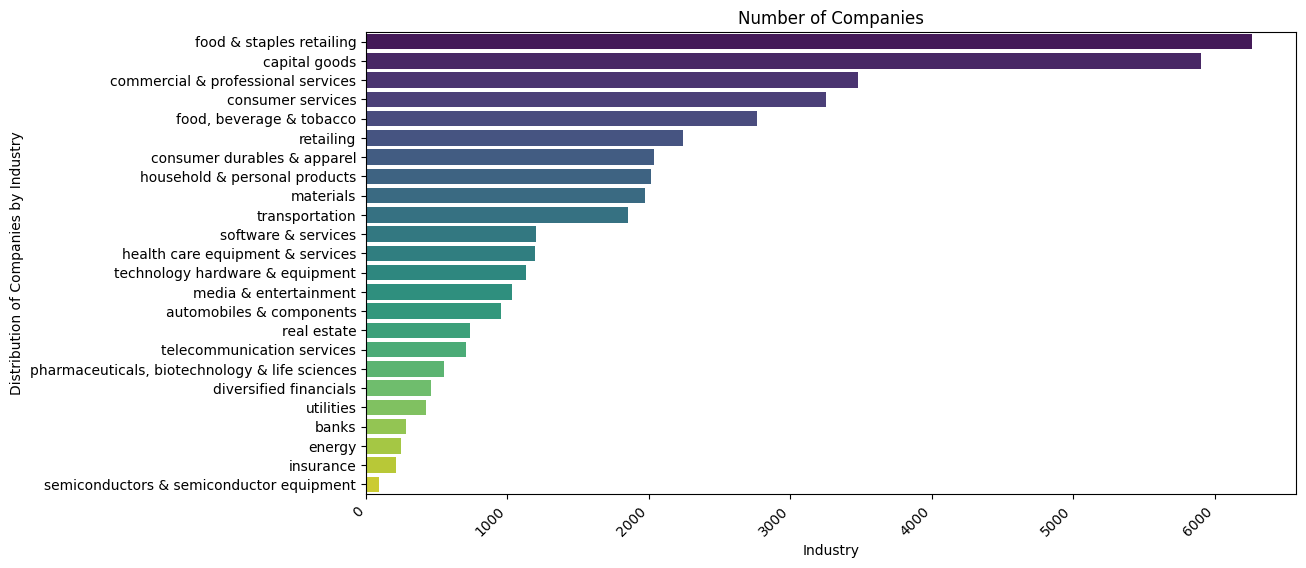

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

industry_counts = df_client_clean['INDUSTRY'].value_counts(dropna=False)
plt.figure(figsize=(12,6))
sns.barplot(x=industry_counts.values, y=industry_counts.index, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Number of Companies')
plt.ylabel('Distribution of Companies by Industry')
plt.xlabel('Industry')
plt.show()


C:\Users\Sara Limeta\AppData\Local\Temp\ipykernel_18900\3701663256.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_subindustries.values, y=top_subindustries.index, palette='magma')


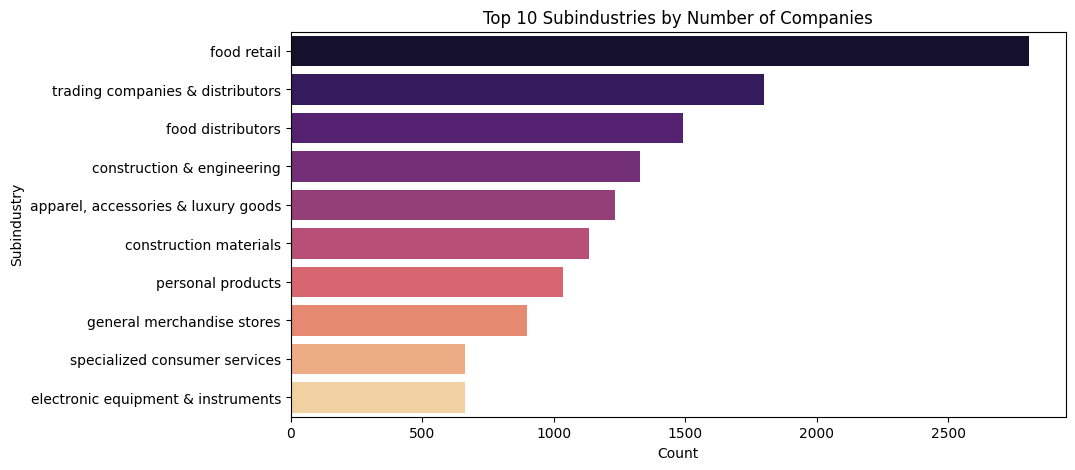

In [ ]:
top_subindustries = df_client_clean['SUB_INDUSTRY'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_subindustries.values, y=top_subindustries.index, palette='magma')
plt.title('Top 10 Subindustries by Number of Companies')
plt.xlabel('Count')
plt.ylabel('Subindustry')
plt.show()


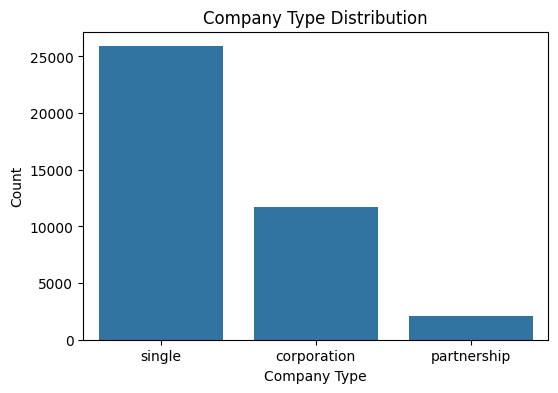

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_client_clean, x='COMPANY_TYPE', order=df_client_clean['COMPANY_TYPE'].value_counts().index)
plt.title('Company Type Distribution')
plt.xlabel('Company Type')
plt.ylabel('Count')
plt.show()


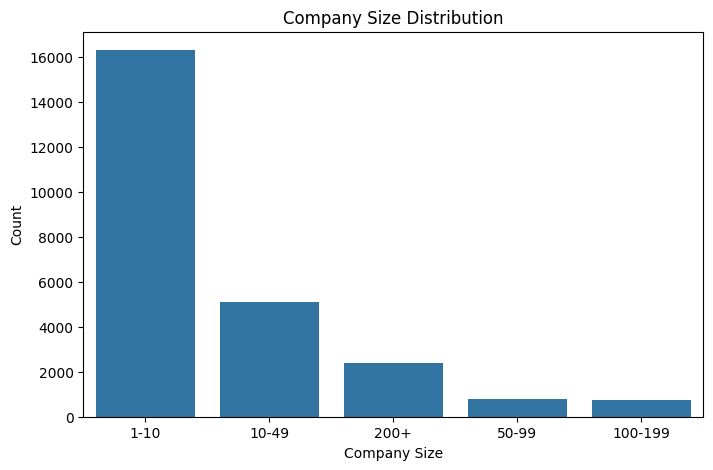

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=df_client_clean, x='COMPANY_SIZE', order=df_client_clean['COMPANY_SIZE'].value_counts().index)
plt.title('Company Size Distribution')
plt.xlabel('Company Size')
plt.ylabel('Count')
plt.show()


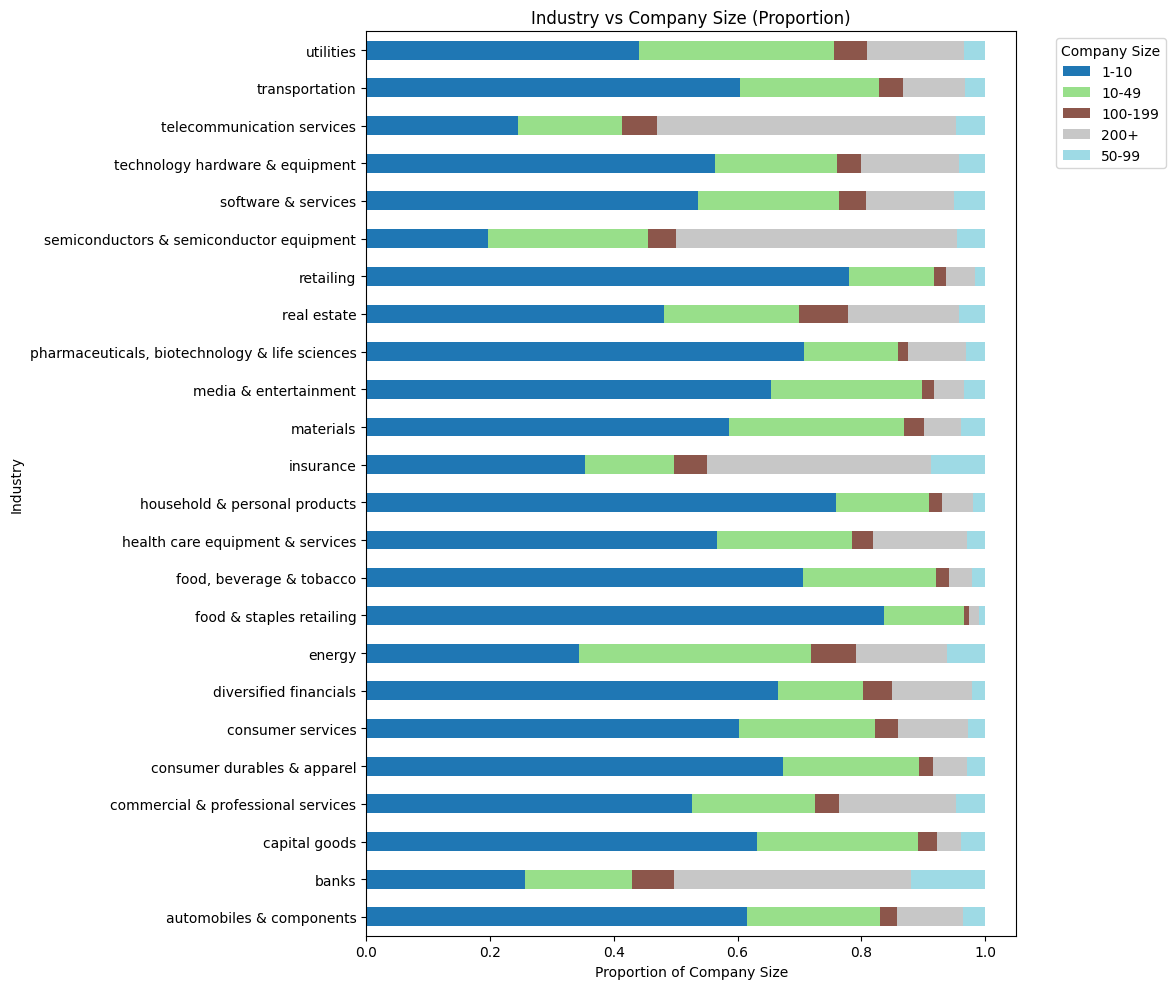

In [ ]:
industry_size = pd.crosstab(df_client_clean['INDUSTRY'], df_client_clean['COMPANY_SIZE'])
industry_size_norm = industry_size.div(industry_size.sum(axis=1), axis=0)

# Plot horizontal stacked bars (industry on y-axis, company sizes stacked)
industry_size_norm.plot(kind='barh', stacked=True, figsize=(12,10), colormap='tab20')
plt.title('Industry vs Company Size (Proportion)')
plt.xlabel('Proportion of Company Size')
plt.ylabel('Industry')
plt.legend(title='Company Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
df_client_clean.to_csv('../data/dim_client_cleaned.csv', index=False)


# Loan Details

## Initial EDA

In [ ]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18057 entries, 0 to 18056
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CLIENT_UUID                    18057 non-null  int64  
 1   LOAN_UUID                      18057 non-null  int64  
 2   CONTRACT_DATE                  18057 non-null  object 
 3   INITIAL_LOAN_AMOUNT            18057 non-null  float64
 4   LOAN_END_DATE                  18054 non-null  object 
 5   ORIGINAL_LOAN_END_DATE         18037 non-null  object 
 6   CURRENT_PRINCIPAL_OUTSTANDING  18057 non-null  float64
 7   DAYS_PAST_DUE                  2083 non-null   float64
 8   SEGMENT                        18047 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 1.2+ MB


In [ ]:
df_loan.sample(10)

,CLIENT_UUID,LOAN_UUID,CONTRACT_DATE,INITIAL_LOAN_AMOUNT,LOAN_END_DATE,ORIGINAL_LOAN_END_DATE,CURRENT_PRINCIPAL_OUTSTANDING,DAYS_PAST_DUE,SEGMENT
1400,135154,28088,2019-08-04,96120.00,2019-12-06,2019-11-05,0.000000e+00,NaN,Segment 2
16052,130034,22082,2020-02-01,289254.00,2021-12-27,2020-06-02,2.892540e+05,632.0,Segment 2
4652,129803,30065,2019-06-10,219030.00,2019-07-22,2019-07-22,0.000000e+00,NaN,Segment 1
8597,42490,7867,2023-08-18,7500000.00,2024-02-16,2024-02-16,6.959579e+06,NaN,Segment 3
5316,82238,23299,2019-12-21,81760.00,2020-02-20,2020-02-20,8.176000e+04,1294.0,Segment 1
13194,140285,31124,2019-05-17,97185.60,2019-09-23,2019-09-23,0.000000e+00,NaN,Segment 2
6325,139903,35128,2019-01-11,77400.00,2019-05-16,2019-04-24,0.000000e+00,NaN,Segment 2
15474,131467,31583,2019-05-05,147889.77,2019-10-07,2019-10-07,0.000000e+00,NaN,Segment 4
2668,131981,26527,2019-09-26,225600.00,2019-11-29,2019-11-29,0.000000e+00,NaN,Segment 2
6841,151781,21324,2020-02-20,21363.28,2020-03-17,2020-03-17,0.000000e+00,NaN,Segment 1


In [ ]:
print("\nMissing / 'NA' values per column:")
for col in df_loan.columns:
    missing_count = df_loan[col].isna().sum()
    na_str_count = (df_loan[col] == 'NA').sum() if df_loan[col].dtype == 'object' else 0
    print(f" {col}: missing={missing_count}, 'NA' strings={na_str_count}")



Missing / 'NA' values per column:
 CLIENT_UUID: missing=0, 'NA' strings=0
 LOAN_UUID: missing=0, 'NA' strings=0
 CONTRACT_DATE: missing=0, 'NA' strings=0
 INITIAL_LOAN_AMOUNT: missing=0, 'NA' strings=0
 LOAN_END_DATE: missing=3, 'NA' strings=0
 ORIGINAL_LOAN_END_DATE: missing=20, 'NA' strings=0
 CURRENT_PRINCIPAL_OUTSTANDING: missing=0, 'NA' strings=0
 DAYS_PAST_DUE: missing=15974, 'NA' strings=0
 SEGMENT: missing=10, 'NA' strings=0


In [ ]:
# Convert UUIDs to string
# Convert UUIDs to string
df_loan['CLIENT_UUID'] = df_loan['CLIENT_UUID'].astype(str)
df_loan['LOAN_UUID'] = df_loan['LOAN_UUID'].astype(str)

# Convert dates
df_loan['CONTRACT_DATE'] = pd.to_datetime(df_loan['CONTRACT_DATE'], errors='coerce')
df_loan['LOAN_END_DATE'] = pd.to_datetime(df_loan['LOAN_END_DATE'], errors='coerce')
df_loan['ORIGINAL_LOAN_END_DATE'] = pd.to_datetime(df_loan['ORIGINAL_LOAN_END_DATE'], errors='coerce')


df_loan['DAYS_PAST_DUE'] = df_loan['DAYS_PAST_DUE'].astype('Int64')

df_loan['SEGMENT'] = df_loan['SEGMENT'].astype(str)


In [ ]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18057 entries, 0 to 18056
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   CLIENT_UUID                    18057 non-null  object        
 1   LOAN_UUID                      18057 non-null  object        
 2   CONTRACT_DATE                  18057 non-null  datetime64[ns]
 3   INITIAL_LOAN_AMOUNT            18057 non-null  float64       
 4   LOAN_END_DATE                  18054 non-null  datetime64[ns]
 5   ORIGINAL_LOAN_END_DATE         18037 non-null  datetime64[ns]
 6   CURRENT_PRINCIPAL_OUTSTANDING  18057 non-null  float64       
 7   DAYS_PAST_DUE                  2083 non-null   Int64         
 8   SEGMENT                        18057 non-null  object        
dtypes: Int64(1), datetime64[ns](3), float64(2), object(3)
memory usage: 1.3+ MB


In [ ]:
import pandas as pd

# Check for negative amounts in key columns
amount_cols = [
    "CURRENT_PRINCIPAL_OUTSTANDING",
    "INITIAL_LOAN_AMOUNT",  
    "DAYS_PAST_DUE"
]

for col in amount_cols:
    if col in df_loan.columns:
        neg_vals = df_loan[df_loan[col] < 0]
        print(f"Negative values in {col}: {len(neg_vals)}")
       


Negative values in CURRENT_PRINCIPAL_OUTSTANDING: 0
Negative values in INITIAL_LOAN_AMOUNT: 0
Negative values in DAYS_PAST_DUE: 0


In [ ]:
date_cols = ["CONTRACT_DATE"]

for col in date_cols:
    if col in df_loan.columns:
        # Check for missing or null dates
        missing_dates = df_loan[df_loan[col].isna()]
        print(f"Missing values in {col}: {len(missing_dates)}")
        
        # Check for future dates (assuming today is pd.Timestamp.today())
        future_dates = df_loan[df_loan[col] > pd.Timestamp.today()]
        print(f"Future dates in {col}: {len(future_dates)}\n")

Missing values in CONTRACT_DATE: 0
Future dates in CONTRACT_DATE: 0



In [ ]:
if ("CONTRACT_DATE" in df_loan.columns) and ("LOAN_END_DATE" in df_loan.columns):
    invalid_date_order = df_loan[df_loan["LOAN_END_DATE"] < df_loan["CONTRACT_DATE"]]
    print(f"LOAN_END_DATE before CONTRACT_DATE: {len(invalid_date_order)}\n")

LOAN_END_DATE before CONTRACT_DATE: 0



In [ ]:
if ("CONTRACT_DATE" in df_loan.columns) and ("ORIGINAL_LOAN_END_DATE" in df_loan.columns):
    invalid_date_order = df_loan[df_loan["ORIGINAL_LOAN_END_DATE"] < df_loan["CONTRACT_DATE"]]
    print(f"ORIGINAL_LOAN_END_DATE before CONTRACT_DATE: {len(invalid_date_order)}\n")

ORIGINAL_LOAN_END_DATE before CONTRACT_DATE: 0



In [ ]:
if ("ORIGINAL_LOAN_END_DATE" in df_loan.columns) and ("LOAN_END_DATE" in df_loan.columns):
    invalid_date_order = df_loan[df_loan["LOAN_END_DATE"] < df_loan["ORIGINAL_LOAN_END_DATE"]]
    print(f"LOAN_END_DATE before ORIGINAL_LOAN_END_DATE: {len(invalid_date_order)}\n")

LOAN_END_DATE before ORIGINAL_LOAN_END_DATE: 552



Loan end date that is before original loan end date should have 0 outstanding balance and no days past due because it means it has been paid early

In [ ]:
if ("ORIGINAL_LOAN_END_DATE" in df_loan.columns) and ("LOAN_END_DATE" in df_loan.columns):
    invalid_date_order = df_loan[df_loan["LOAN_END_DATE"] < df_loan["ORIGINAL_LOAN_END_DATE"]]
    print(f"LOAN_END_DATE before ORIGINAL_LOAN_END_DATE: {len(invalid_date_order)}\n")
    
    unique_principal = invalid_date_order["CURRENT_PRINCIPAL_OUTSTANDING"].unique()
    unique_days_past_due = invalid_date_order["DAYS_PAST_DUE"].unique()
    
    print("Unique CURRENT_PRINCIPAL_OUTSTANDING values:")
    print(unique_principal)
    print("\nUnique DAYS_PAST_DUE values:")
    print(unique_days_past_due)



LOAN_END_DATE before ORIGINAL_LOAN_END_DATE: 552

Unique CURRENT_PRINCIPAL_OUTSTANDING values:
[0.]

Unique DAYS_PAST_DUE values:
<IntegerArray>
[<NA>]
Length: 1, dtype: Int64


In [ ]:
print(df_loan[amount_cols].describe())

       CURRENT_PRINCIPAL_OUTSTANDING  INITIAL_LOAN_AMOUNT  DAYS_PAST_DUE
count                   1.805700e+04         1.805700e+04         2083.0
mean                    7.547127e+04         4.829442e+05    1061.855497
std                     3.663141e+05         8.678183e+05     425.569168
min                     0.000000e+00         4.034600e+02            1.0
25%                     0.000000e+00         6.468000e+04          810.0
50%                     0.000000e+00         1.669981e+05         1204.0
75%                     0.000000e+00         4.766250e+05         1331.0
max                     1.000000e+07         1.000000e+07         1693.0


In [ ]:
date_cols = [col for col in df_loan.columns if "DATE" in col and pd.api.types.is_datetime64_any_dtype(df_loan[col])]

for col in date_cols:
    print(f"\nSummary for {col}:")
    print(f"  Min:  {df_loan[col].min()}")
    print(f"  Max:  {df_loan[col].max()}")
    print(f"  Count: {df_loan[col].count()}")
    print(f"  Missing: {df_loan[col].isna().sum()}")




Summary for CONTRACT_DATE:
  Min:  2019-01-05 00:00:00
  Max:  2023-09-05 00:00:00
  Count: 18057
  Missing: 0

Summary for LOAN_END_DATE:
  Min:  2019-01-17 00:00:00
  Max:  2025-04-27 00:00:00
  Count: 18054
  Missing: 3

Summary for ORIGINAL_LOAN_END_DATE:
  Min:  2019-01-17 00:00:00
  Max:  2024-09-04 00:00:00
  Count: 18037
  Missing: 20


In [ ]:

if "SEGMENT" in df_loan.columns:
    print("Unique values in SEGMENT:")
    print(df_loan["SEGMENT"].value_counts(dropna=False))
else:
    print("'SEGMENT' column not found in the DataFrame.")


Unique values in SEGMENT:
SEGMENT
Segment 1    10409
Segment 2     7281
Segment 3      276
Segment 4       81
nan             10
Name: count, dtype: int64


It was initially assumed that DAYS_PAST_DUE could be derived from the difference between the extraction date (September 6, 2023) and LOAN_END_DATE. While this held true for many records, inconsistencies in the data suggested that multiple extraction dates may exist. Due to this uncertainty, no imputation was applied to fill missing values in DAYS_PAST_DUE or LOAN_END_DATE to avoid introducing inaccurate assumptions.

In [ ]:


df_temp = df_loan.dropna(subset=["ORIGINAL_LOAN_END_DATE", "DAYS_PAST_DUE"])


df_temp["ORIG_END_PLUS_DPD"] = df_temp["ORIGINAL_LOAN_END_DATE"] + pd.to_timedelta(df_temp["DAYS_PAST_DUE"], unit='D')


value_counts = df_temp["ORIG_END_PLUS_DPD"].value_counts().sort_values(ascending=False)


print(value_counts)


ORIG_END_PLUS_DPD
2023-09-06    624
2023-08-06     88
2023-08-07     61
2023-07-08     47
2023-08-30     31
             ... 
2023-12-04      1
2023-02-09      1
2023-04-06      1
2024-03-28      1
2022-07-03      1
Name: count, Length: 531, dtype: int64


C:\Users\Sara Limeta\AppData\Local\Temp\ipykernel_18900\493435563.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["ORIG_END_PLUS_DPD"] = df_temp["ORIGINAL_LOAN_END_DATE"] + pd.to_timedelta(df_temp["DAYS_PAST_DUE"], unit='D')


In [ ]:

value_counts_sorted_by_date = value_counts.sort_index(ascending=False)

print(value_counts_sorted_by_date)


ORIG_END_PLUS_DPD
2024-07-26    1
2024-07-08    2
2024-07-07    1
2024-07-06    4
2024-06-27    1
             ..
2020-06-29    1
2020-06-20    1
2020-05-29    1
2020-05-15    2
2020-04-28    1
Name: count, Length: 531, dtype: int64


In [ ]:

df_temp = df_loan.dropna(subset=["LOAN_END_DATE", "DAYS_PAST_DUE"])


df_temp["LOAN_END_PLUS_DPD"] = df_temp["LOAN_END_DATE"] + pd.to_timedelta(df_temp["DAYS_PAST_DUE"], unit='D')


value_counts = df_temp["LOAN_END_PLUS_DPD"].value_counts().sort_values(ascending=False)


print(value_counts)

LOAN_END_PLUS_DPD
2023-09-06    1536
2023-10-07      47
2024-02-06      35
2023-11-06      34
2023-12-07      29
              ... 
2023-12-10       1
2024-06-15       1
2025-03-08       1
2024-12-06       1
2024-03-25       1
Name: count, Length: 145, dtype: int64


C:\Users\Sara Limeta\AppData\Local\Temp\ipykernel_18900\2726147158.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["LOAN_END_PLUS_DPD"] = df_temp["LOAN_END_DATE"] + pd.to_timedelta(df_temp["DAYS_PAST_DUE"], unit='D')


In [ ]:

value_counts_sorted_by_date = value_counts.sort_index(ascending=False)

print(value_counts_sorted_by_date)

LOAN_END_PLUS_DPD
2026-06-10       1
2026-01-13       1
2025-09-05       1
2025-08-08       2
2025-08-06       8
              ... 
2023-09-15       1
2023-09-13       1
2023-09-12       1
2023-09-10       1
2023-09-06    1536
Name: count, Length: 145, dtype: int64


In [ ]:

exclude_date = pd.Timestamp('2023-09-06')


filtered_records = df_temp[df_temp["LOAN_END_PLUS_DPD"] != exclude_date]


filtered_records


,CLIENT_UUID,LOAN_UUID,CONTRACT_DATE,INITIAL_LOAN_AMOUNT,LOAN_END_DATE,ORIGINAL_LOAN_END_DATE,CURRENT_PRINCIPAL_OUTSTANDING,DAYS_PAST_DUE,SEGMENT,LOAN_END_PLUS_DPD
2,44879,10054,2023-03-23,456382.17,2023-09-23,2023-09-23,2.858487e+05,96,Segment 2,2023-12-28
6,31504,14144,2022-07-25,2000000.00,2023-08-24,2023-07-25,3.781601e+05,58,Segment 2,2023-10-21
7,28465,9853,2023-04-05,2147853.88,2024-04-05,2024-04-05,1.500226e+06,1,Segment 2,2024-04-06
131,91007,20311,2020-03-30,41560.42,2022-07-24,2020-09-18,4.156042e+04,559,Segment 1,2024-02-03
150,110549,20604,2020-03-14,359081.73,2021-06-22,2020-04-11,3.578771e+05,1110,Segment 1,2024-07-06
...,...,...,...,...,...,...,...,...,...,...
17913,76140,23890,2019-12-07,409794.30,2023-07-20,2020-01-15,0.000000e+00,474,Segment 1,2024-11-05
17916,121050,20634,2020-03-14,130498.88,2022-02-15,2020-06-13,1.304989e+05,630,Segment 1,2023-11-07
17947,149175,14340,2022-07-18,2000000.00,2023-07-18,2023-07-18,7.371366e+05,141,Segment 2,2023-12-06
17948,76931,21186,2020-02-23,30745.80,2021-06-15,2020-04-07,3.074580e+04,905,Segment 1,2023-12-07


In [ ]:
count_nonnull_dpd_zero_principal = df_loan[
    (df_loan["CURRENT_PRINCIPAL_OUTSTANDING"] == 0) &
    (df_loan["DAYS_PAST_DUE"].notnull())
].shape[0]

print(f"Number of records with CURRENT_PRINCIPAL_OUTSTANDING = 0 and non-null DAYS_PAST_DUE: {count_nonnull_dpd_zero_principal}")


Number of records with CURRENT_PRINCIPAL_OUTSTANDING = 0 and non-null DAYS_PAST_DUE: 156


In [ ]:
counts = df_loan.loc[df_loan["DAYS_PAST_DUE"].isnull(), "CURRENT_PRINCIPAL_OUTSTANDING"].value_counts()
print(counts)


CURRENT_PRINCIPAL_OUTSTANDING
0.000000e+00    15224
5.000000e+05       29
1.000000e+06       23
2.500000e+05       21
2.000000e+06       11
                ...  
1.776285e+05        1
1.127513e+05        1
5.186611e+05        1
9.473511e+05        1
1.800000e+06        1
Name: count, Length: 591, dtype: int64


## Data Cleaning

### dropping duplicates (same for all columns except loan_uuid)

In [ ]:
# Exclude CLIENT_UUID and LOAN_UUID
cols_to_check = df_loan.columns.difference(['LOAN_UUID'])

# Find duplicates based on all other columns
duplicates = df_loan[df_loan.duplicated(subset=cols_to_check, keep=False)]

# View the number of duplicates
print(f"Number of duplicated rows (except LOAN_UUID): {duplicates.shape[0]}")

# Display sample of duplicates (optional)
duplicates.sort_values(by=cols_to_check.tolist()).head(10)


Number of duplicated rows (LOAN_UUID): 104


,CLIENT_UUID,LOAN_UUID,CONTRACT_DATE,INITIAL_LOAN_AMOUNT,LOAN_END_DATE,ORIGINAL_LOAN_END_DATE,CURRENT_PRINCIPAL_OUTSTANDING,DAYS_PAST_DUE,SEGMENT
4379,102103,29706,2019-06-16,132440.00,2019-07-12,2019-07-12,0.0,<NA>,Segment 1
17382,102103,29698,2019-06-16,132440.00,2019-07-12,2019-07-12,0.0,<NA>,Segment 1
5784,108182,28055,2019-08-05,194000.00,2019-09-13,2019-08-30,0.0,<NA>,Segment 1
7482,108182,28056,2019-08-05,194000.00,2019-09-13,2019-08-30,0.0,<NA>,Segment 1
8020,108182,28057,2019-08-05,194000.00,2019-09-13,2019-08-30,0.0,<NA>,Segment 1
5214,109093,30115,2019-06-09,400000.00,2019-09-30,2019-07-11,0.0,<NA>,Segment 2
6702,109093,30120,2019-06-09,400000.00,2019-09-30,2019-07-11,0.0,<NA>,Segment 2
7799,109093,30118,2019-06-09,400000.00,2019-09-30,2019-07-11,0.0,<NA>,Segment 2
10903,109607,29619,2019-06-20,172196.05,2019-08-26,2019-08-26,0.0,<NA>,Segment 1
11496,109607,29620,2019-06-20,172196.05,2019-08-26,2019-08-26,0.0,<NA>,Segment 1


In [ ]:
# dropping duplicates based on all columns except LOAN_UUID which is unique
df_loan = df_loan.drop_duplicates(subset=cols_to_check, keep='first')

# Exclude CLIENT_UUID and LOAN_UUID
cols_to_check = df_loan.columns.difference(['LOAN_UUID'])

# Find duplicates based on all other columns
duplicates = df_loan[df_loan.duplicated(subset=cols_to_check, keep=False)]

# View the number of duplicates
print(f"Number of duplicated rows (excluding CLIENT_UUID & LOAN_UUID): {duplicates.shape[0]}")

Number of duplicated rows (excluding CLIENT_UUID & LOAN_UUID): 0


In [ ]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17997 entries, 0 to 18056
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   CLIENT_UUID                    17997 non-null  object        
 1   LOAN_UUID                      17997 non-null  object        
 2   CONTRACT_DATE                  17997 non-null  datetime64[ns]
 3   INITIAL_LOAN_AMOUNT            17997 non-null  float64       
 4   LOAN_END_DATE                  17994 non-null  datetime64[ns]
 5   ORIGINAL_LOAN_END_DATE         17977 non-null  datetime64[ns]
 6   CURRENT_PRINCIPAL_OUTSTANDING  17997 non-null  float64       
 7   DAYS_PAST_DUE                  2078 non-null   Int64         
 8   SEGMENT                        17997 non-null  object        
dtypes: Int64(1), datetime64[ns](3), float64(2), object(3)
memory usage: 1.4+ MB


In [ ]:
df_loan.to_csv('../data/loan_details_cleaned.csv', index=False)